In [65]:
import numpy as np
import pandas as pd
import re
import string,time
import nltk
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [66]:
data = pd.read_csv("./Downloads/Soft_Computing/archive/Tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [67]:
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [68]:
data.shape

(14640, 15)

In [5]:
data['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

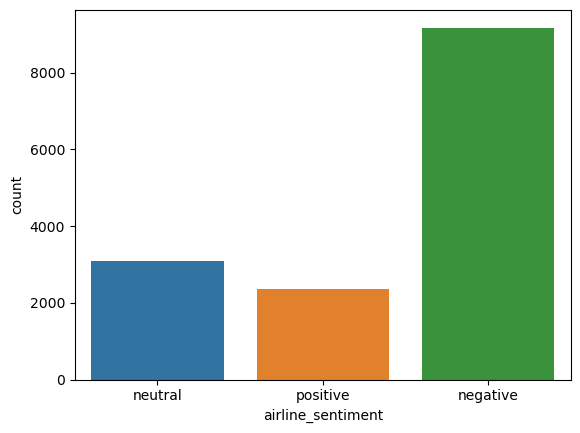

In [6]:
#plotting the Airline Sentiment

air_plot = sns.countplot(x = "airline_sentiment",data = data)

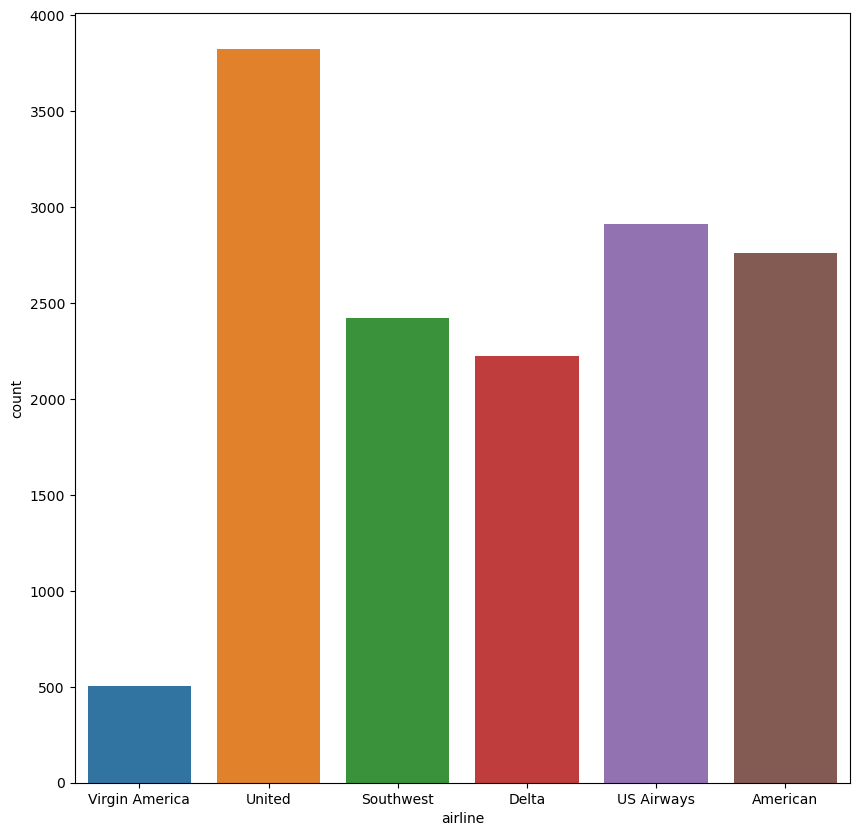

In [7]:
# Types of Airlines

plt.figure(figsize = (10,10))
air_plot = sns.countplot(x = 'airline',data = data)

In [8]:
# Data Preprocessing 
# Converting all the text to Lowercase
data['text'].str.lower


<bound method StringMethods.lower of <pandas.core.strings.accessor.StringMethods object at 0x7fb7463afa10>>

In [9]:
data['text']

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [10]:
# Removing html tags
def remove_html_tags(review):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'',review)

data['text'] = data['text'].apply(remove_html_tags)

In [11]:
data['text'].head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [12]:
# Removing URL's  
def remove_url(review):
    pattern=re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'',review)


data['text'] = data['text'].apply(remove_url)


In [13]:
data['text'].head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [14]:
# Removing Punctutaions
exclude = string.punctuation

def remove_punc(review):
    for char in exclude:
        review = review.replace(char,'')
        
    return review

start = time.time()
data['text'] = data['text'].apply(remove_punc)
time1 = time.time() - start
print(time1)


0.04315066337585449


In [15]:
data['text'].head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus youve added commercials to ...
2    VirginAmerica I didnt today Must mean I need t...
3    VirginAmerica its really aggressive to blast o...
4    VirginAmerica and its a really big bad thing a...
Name: text, dtype: object

In [16]:
# Chat Word Treatment
# rofl.lmao,jmho,fyi,asap,gn  
acronyms_data = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you (also a chat program)',
    'ILU': 'I Love You',
    'IMHO': 'In My Honest/Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My A.. Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'PITA': 'Pain In The A..',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My A.. Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The F...',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait...',
    '7K': 'Sick:-D Laughter',
    'TFW': 'That feeling when. TFW internet slang often goes in a caption to an image.',
    'MFW': 'My face when',
    'MRW': 'My reaction when',
    'IFYP': 'I feel your pain',
    'LOL': 'Laughing out loud',
    'TNTL': 'Trying not to laugh',
    'JK': 'Just kidding',
    'IDC': 'I don’t care',
    'ILY': 'I love you',
    'IMU': 'I miss you',
    'ADIH': 'Another day in hell',
    'IDC': 'I don’t care',
    'ZZZ': 'Sleeping, bored, tired',
    'WYWH': 'Wish you were here',
    'TIME': 'Tears in my eyes',
    'BAE': 'Before anyone else',
    'FIMH': 'Forever in my heart',
    'BSAAW': 'Big smile and a wink',
    'BWL': 'Bursting with laughter',
    'LMAO': 'Laughing my a** off',
    'BFF': 'Best friends forever',
    'CSL': 'Can’t stop laughing',
}


def chat_conversion(review):
    new_text = []
    for w in review.split():
        if w.upper() in acronyms_data:
            new_text.append(acronyms_data[w.upper()])
        else:
            new_text.append(w)
            
    return " ".join(new_text)
    
data['text'] = data['text'].apply(chat_conversion)

In [17]:
data['text'][7160:7169]

7160     Laughing my a** off “JetBlue Our fleets on fleek
7161                                    JetBlue I digg it
7162              JetBlue BrandsSayingBae well here we go
7163    JetBlue I want you guys to be the first to fly...
7164                     Haha JetBlue Our fleets on fleek
7165    “JetBlue Our fleets on fleek alynewton new fav...
7166    JetBlue Hopefully now my application for JetBl...
7167                                       JetBlue really
7168                                 JetBlue Looking cool
Name: text, dtype: object

In [18]:
#Spelling Correction
from textblob import TextBlob


data['text'] = data['text'].apply(lambda x: TextBlob(str(x)).correct().string)
print(data['text'])


In [19]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
# Removing stop words like a,the,me,i
stopwords.words('english')

def remove_stopwords(review):
    new_text = []
    for word in review.split():
        if word in stopwords.words('english'):
            new_text.append('')
            
        else:
            new_text.append(word)
            
        x = new_text[:]
        new_text.clear()
        return ''.join(x)
    
data['text'].apply(remove_stopwords)
data['text'].head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus youve added commercials to ...
2    VirginAmerica I didnt today Must mean I need t...
3    VirginAmerica its really aggressive to blast o...
4    VirginAmerica and its a really big bad thing a...
Name: text, dtype: object

In [21]:


#Remove Emojis or replace them with their meaning
# def remove_emojis(review):
#     emoji_pattern = re.compile("["
#                                u"\U0001F600-\U0001F64F",  # Emoticons
#                                u"\U0001F300-\U0001F5FF", # Symbols 
#                                u"\U0001F680-\U0001F6FF",  # Transport and map symbols
#                                u"\U0001F1E0-\U0001F!FF",  # flags(ios)
#                                u"\U00012702-\U000027B0",
#                                u"\U000024C2-\U0001F251"
#                                "]+", flags=re.UNICODE)
    
#     return emoji_pattern.sub(r'', review)
# data['text'] = data['text'].apply(remove_emojis)
# print(data['text'])

emoji.demojize(data['text'])
print(data['text'].head())

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus youve added commercials to ...
2    VirginAmerica I didnt today Must mean I need t...
3    VirginAmerica its really aggressive to blast o...
4    VirginAmerica and its a really big bad thing a...
Name: text, dtype: object


In [22]:
# I am tokenizing the tweet and also taking tokens from first index onwards as initital to gives airline name and 
# lowering them and later making it back a sentence
def clean_the_tweet(review):
    tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",review))
    tokens = [token.lower() for token in tokens]
    return ' '.join(tokens[1:])

data['text'] = data['text'].apply(lambda x: clean_the_tweet(x))
print(data['text'][:])

0                                       what dhepburn said
1        plus youve added commercials to the experience...
2        i didnt today must mean i need to take another...
3        its really aggressive to blast obnoxious enter...
4                  and its a really big bad thing about it
                               ...                        
14635    thank you we got on a different flight to chicago
14636    leaving over minutes late flight no warnings o...
14637         please bring american airlines to blackberry
14638    you have my money you change my flight and don...
14639    we have ppl so we need know how many seats are...
Name: text, Length: 14640, dtype: object


In [23]:
''' Inflection which mean modification to express different grammatical categories such as 
tense, case, voice, aspect, person , number, gender and mood
Stemming is the process of reducing inflection in words to their root forms such as mapping a group of of words
to the same stem even if the stem itself is not a valid word in the language. It is used when we need speed or want 
our job to be done quickly as possible . But if we want to show the output to the user lemmatization is preferred 
which is a bit slower'''

ps = PorterStemmer()
def stem_words(review):
    
    return " ".join([ps.stem(word) for word in str(review).split(" ")])

data['text'] = data['text'].apply(stem_words)
data['text'][7:20]



7     realli miss a prime opportun for men without h...
8                           well i didnt but now i do d
9     it wa amaz and arriv an hour earli your too go...
10    did you know that suicid is the second lead ca...
11    i lt pretti graphic so much better than minim ...
12    thi is such a great deal alreadi think about m...
13    virginmedia im fli your fabul seduct sky again...
14                                                thank
15                          sfopdx schedul is still mia
16    so excit for my first cross countri flight lax...
17    i flew from nyc to sfo last week and couldnt f...
18                                    fli virginamerica
19    you know what would be amazingli awesom bosfll...
Name: text, dtype: object

In [24]:
data['text'][11:24]

11    i lt pretti graphic so much better than minim ...
12    thi is such a great deal alreadi think about m...
13    virginmedia im fli your fabul seduct sky again...
14                                                thank
15                          sfopdx schedul is still mia
16    so excit for my first cross countri flight lax...
17    i flew from nyc to sfo last week and couldnt f...
18                                    fli virginamerica
19    you know what would be amazingli awesom bosfll...
20    whi are your first fare in may over three time...
21                                   i love thi graphic
22    i love the hipster innov you are a feel good b...
23    will you be make bosgtla non stop perman anyti...
Name: text, dtype: object

In [25]:
# Removing the neutral sentiment and encoding the positive as 1 and negative as 0

data = data[data['airline_sentiment']!='neutral']
data['cleaned_tweet'] = data['text'].apply(clean_the_tweet)
data['text'].head()

data['airline_sentiment'] = data['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)
# data.head()
    
# xvy = data['cleaned_tweet'][7:3]
# print(xvy)

In [26]:
# Printing Confusion matrix 
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [27]:
# To check the acurracies,recall,f_1 score,precision  in train and test set

def check_scores(model, x_train, x_test, y_train, y_test):
    # Train the model
    model.fit(x_train.toarray(), y_train)

    # Predict on training and test sets
    train_predictions = model.predict(x_train.toarray())
    test_predictions = model.predict(x_test.toarray())

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    
    # Calculate recall
    train_recall = recall_score(y_train, train_predictions, average='weighted')
    test_recall = recall_score(y_test, test_predictions, average='weighted')
    
    
    # Calculate precision
    train_precision = precision_score(y_train, train_predictions, average='weighted')
    test_precision = precision_score(y_test, test_predictions, average='weighted')
    
    
    # Calculate F1 score
    train_f1 = f1_score(y_train, train_predictions, average='weighted')
    test_f1 = f1_score(y_test, test_predictions, average='weighted')
    
    plot_confusion_matrix(y_train, train_predictions, title='Confusion Matrix - Train Set')
    plot_confusion_matrix(y_test, test_predictions, title='Confusion Matrix - Test Set')

    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        
        'train_recall': train_recall,
        'test_recall': test_recall,

        'train_precision': train_precision,
        'test_precision': test_precision,

        'train_f1': train_f1,
        'test_f1': test_f1
    }




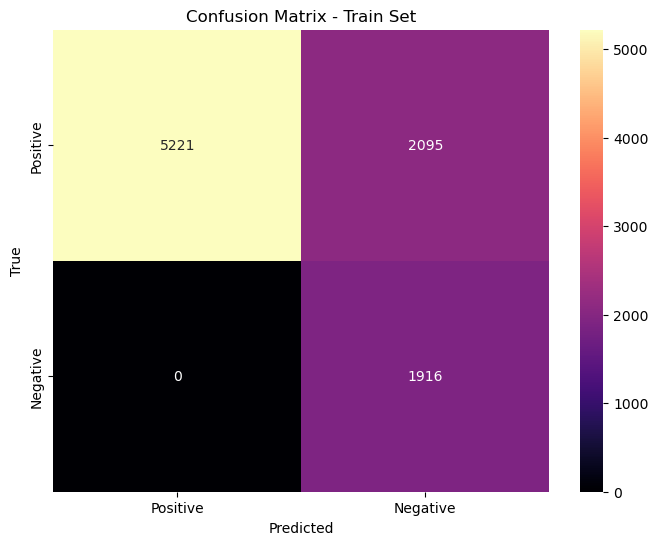

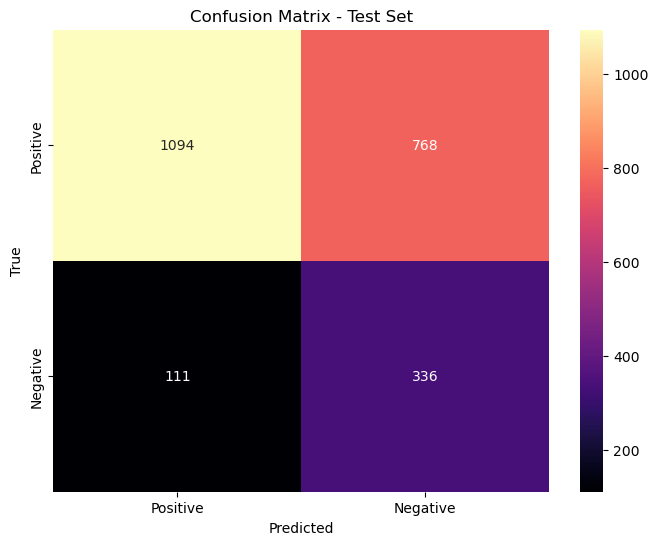

Training Accuracy:   0.7730719237435009
Test Accuracy:       0.6193157210913816

Training Precision:  0.8915995527032031
Test Precision:      0.7910451045087319

Training Recall:     0.7730719237435009
Test Recall:         0.6193157210913816

Training F1 Score:   0.794217287935519
Test F1 Score:       0.6591699071118998


In [28]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(data.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf,data['airline_sentiment'],test_size = 0.2,  random_state=42)



# Create and evaluate Gaussian Naive Bayes model
scores = check_scores(GaussianNB(), x_train, x_test, y_train, y_test)

print("Training Accuracy:  ", scores['train_accuracy'])
print("Test Accuracy:      ", scores['test_accuracy'])


print("\nTraining Precision: ", scores['train_precision'])
print("Test Precision:     ", scores['test_precision'])


print("\nTraining Recall:    ", scores['train_recall'])
print("Test Recall:        ", scores['test_recall'])


print("\nTraining F1 Score:  ", scores['train_f1'])
print("Test F1 Score:      ", scores['test_f1'])


In [134]:
print(X_tf_idf[0])

  (0, 7250)	0.5820350303551166
  (0, 2521)	0.30309354101857555
  (0, 7380)	0.12506513932541988
  (0, 7534)	0.10968114384902779
  (0, 1458)	0.46926208012241843
  (0, 75)	0.4046375069638341
  (0, 8521)	0.3971899728833744


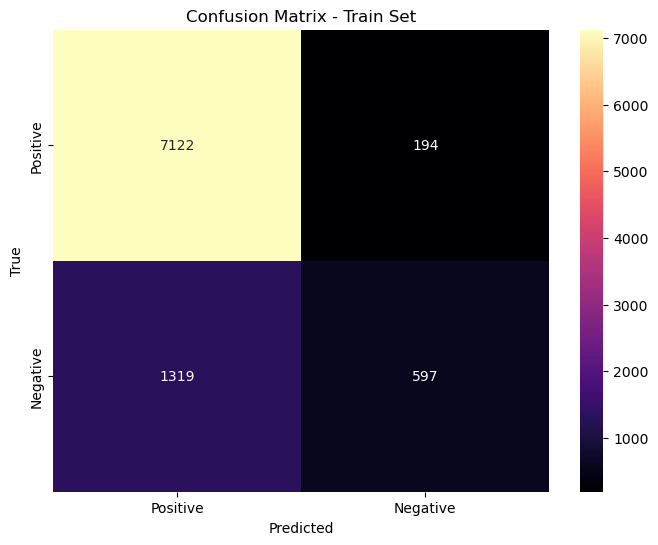

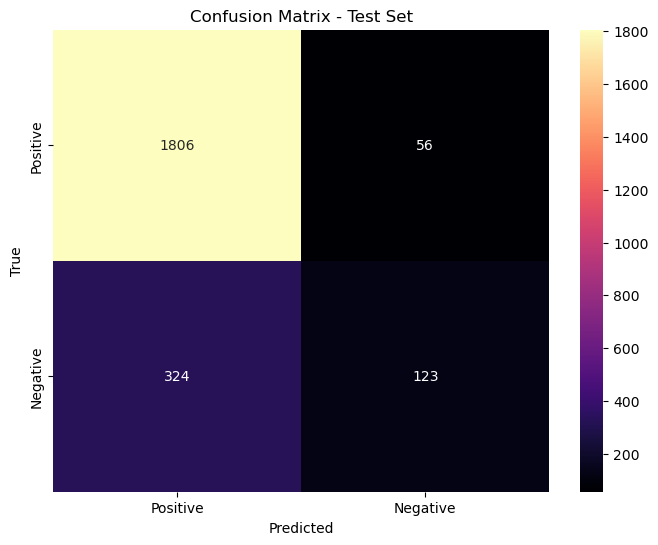

Training Accuracy:   0.8361135181975736
Test Accuracy:       0.8354265915980944

Training Precision:  0.8252683257692995
Test Precision:      0.8167702995946747

Training Recall:     0.8361135181975736
Test Recall:         0.8354265915980944

Training F1 Score:   0.8079092796071142
Test F1 Score:       0.8057226756114768


In [29]:
# Decision tree implementation

dt_model  = check_scores(DecisionTreeClassifier(max_depth=3, random_state=42), x_train, x_test, y_train, y_test)

print("Training Accuracy:  ", dt_model['train_accuracy'])
print("Test Accuracy:      ",dt_model['test_accuracy'])


print("\nTraining Precision: ", dt_model['train_precision'])
print("Test Precision:     ",dt_model['test_precision'])


print("\nTraining Recall:    ", dt_model['train_recall'])
print("Test Recall:        ",dt_model['test_recall'])


print("\nTraining F1 Score:  ", dt_model['train_f1'])
print("Test F1 Score:      ", dt_model['test_f1'])



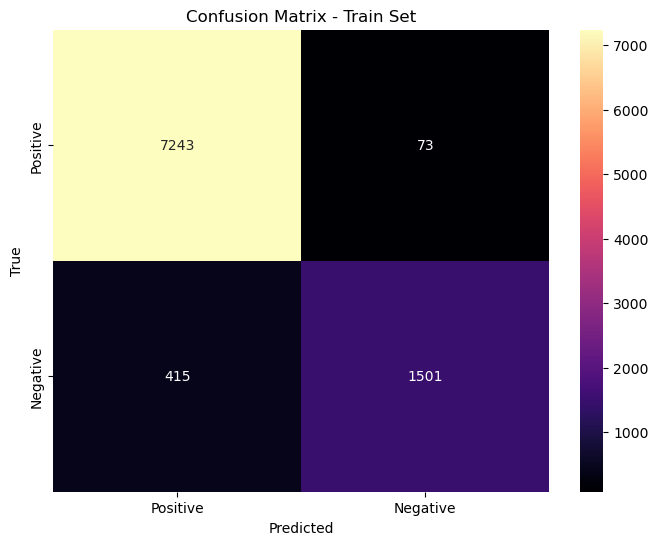

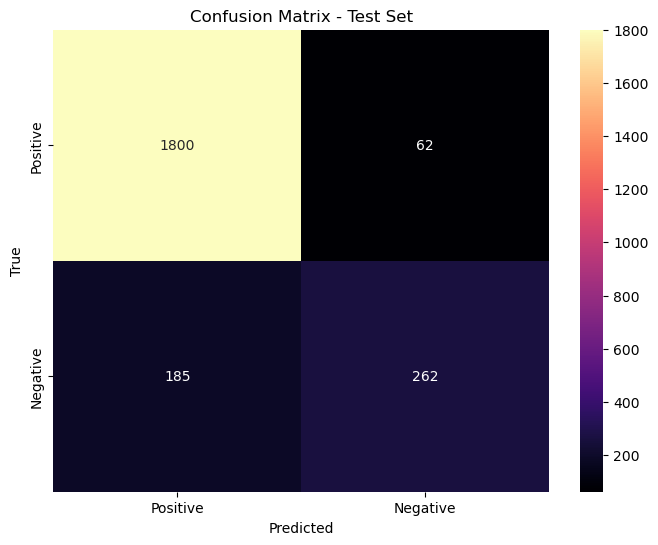

Training Accuracy:   0.9471403812824957
Test Accuracy:       0.8930272845387613

Training Precision:  0.9474298158916247
Test Precision:      0.8877983711708497

Training Recall:     0.9471403812824957
Test Recall:         0.8930272845387613

Training F1 Score:   0.9451540573986296
Test F1 Score:       0.8862045589710545


In [234]:
# Implementing using svm

svm_model = check_scores(SVC(kernel='linear'), x_train, x_test, y_train, y_test)


print("Training Accuracy:  ", svm_model ['train_accuracy'])
print("Test Accuracy:      ",svm_model ['test_accuracy'])


print("\nTraining Precision: ",svm_model ['train_precision'])
print("Test Precision:     ",svm_model ['test_precision'])


print("\nTraining Recall:    ", svm_model ['train_recall'])
print("Test Recall:        ",svm_model ['test_recall'])


print("\nTraining F1 Score:  ", svm_model ['train_f1'])
print("Test F1 Score:      ", svm_model ['test_f1'])


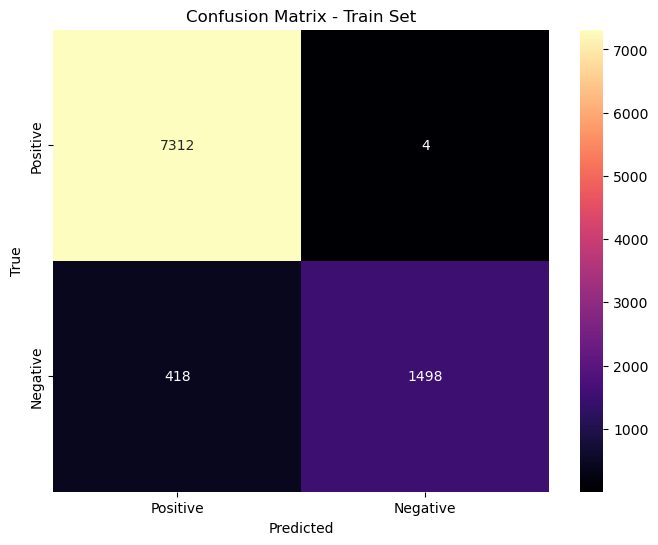

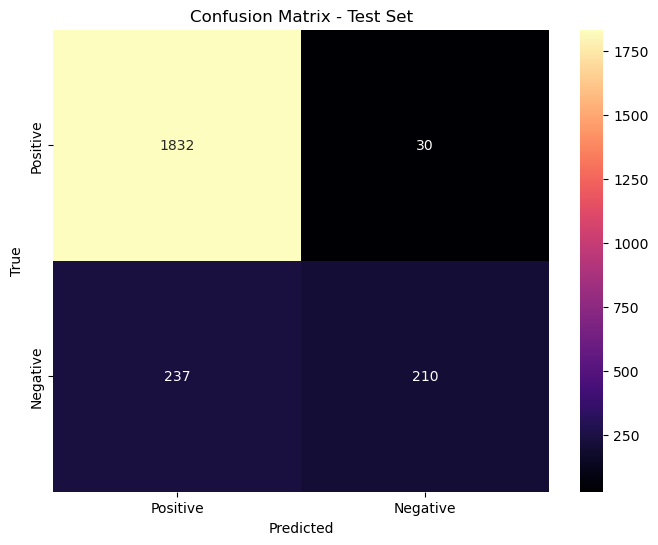

Training Accuracy:   0.9542894280762565
Test Accuracy:       0.884365526201819

Training Precision:  0.9565949451288278
Test Precision:      0.8834285209220817

Training Recall:     0.9542894280762565
Test Recall:         0.884365526201819

Training F1 Score:   0.9521499940049087
Test F1 Score:       0.8699891727082639


In [235]:
# Create SVM and Decision Tree models
svm_model = SVC(kernel='linear')
dt_model = DecisionTreeClassifier()

# Create a Voting Classifier with 'hard' voting strategy
#voting_classifier = VotingClassifier(estimators = ('svm', svm_model), [('dt', dt_model)], voting='hard')
voting_classifier = VotingClassifier(estimators=[('svm', svm_model), ('dt', dt_model)], voting='hard')


smo_dt = check_scores(voting_classifier, x_train, x_test, y_train, y_test)
print("Training Accuracy:  ", smo_dt ['train_accuracy'])
print("Test Accuracy:      ",smo_dt ['test_accuracy'])


print("\nTraining Precision: ",smo_dt  ['train_precision'])
print("Test Precision:     ",smo_dt ['test_precision'])


print("\nTraining Recall:    ", smo_dt ['train_recall'])
print("Test Recall:        ",smo_dt ['test_recall'])


print("\nTraining F1 Score:  ", smo_dt ['train_f1'])
print("Test F1 Score:      ", smo_dt ['test_f1'])

In [217]:
# # Using Adaboost


# adaboost_model=check_scores(AdaBoostClassifier(),x_train,x_test, y_train, y_test)

# print("Training Accuracy:  ", adaboost_model ['train_accuracy'])
# print("Test Accuracy:      ",adaboost_model['test_accuracy'])


# print("\nTraining Precision: ",adaboost_model['train_precision'])
# print("Test Precision:     ",adaboost_model['test_precision'])


# print("\nTraining Recall:    ", adaboost_model['train_recall'])
# print("Test Recall:        ",adaboost_model['test_recall'])


# print("\nTraining F1 Score:  ", adaboost_model['train_f1'])
# print("Test F1 Score:      ", adaboost_model['test_f1'])

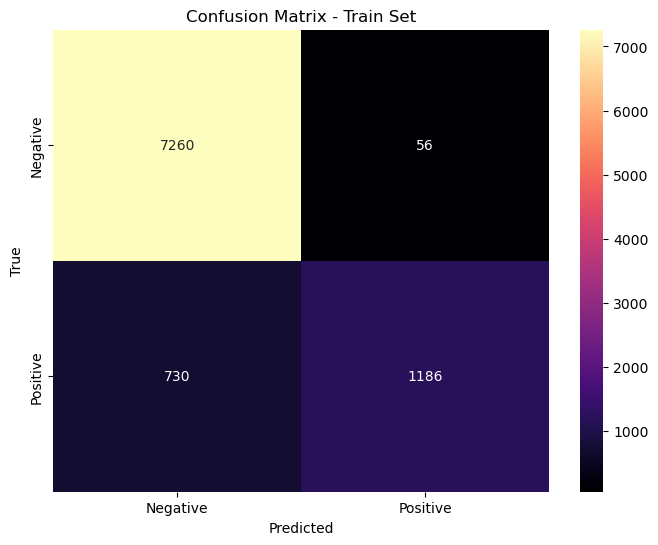

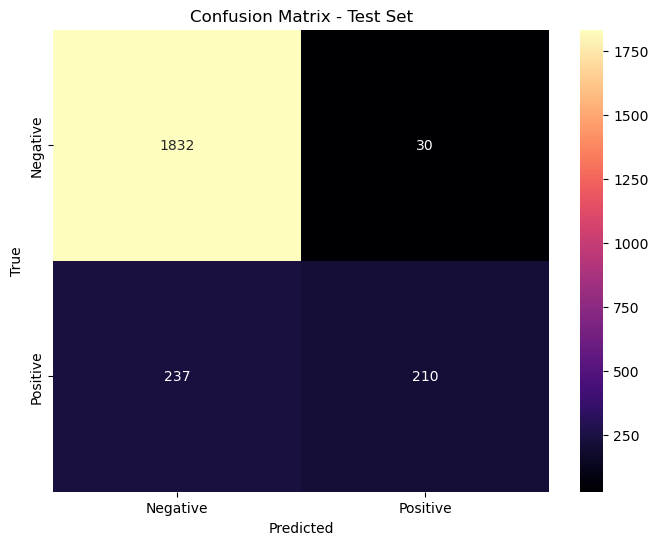

Training Accuracy:   0.9148613518197574
Test Accuracy:       0.884365526201819

Training Precision:  0.9182397942267181
Test Precision:      0.8834285209220817

Training Recall:     0.9148613518197574
Test Recall:         0.884365526201819

Training F1 Score:   0.9076504829213141
Test F1 Score:       0.8699891727082639


In [146]:
# Logistic Regression

modelx = LogisticRegression(random_state=42)
l_r = check_scores(modelx, x_train, x_test, y_train, y_test)

print("Training Accuracy:  ", l_r['train_accuracy'])
print("Test Accuracy:      ", l_r['test_accuracy'])

print("\nTraining Precision: ", l_r['train_precision'])
print("Test Precision:     ", l_r['test_precision'])

print("\nTraining Recall:    ", l_r['train_recall'])
print("Test Recall:        ", l_r['test_recall'])

print("\nTraining F1 Score:  ", l_r['train_f1'])
print("Test F1 Score:      ", l_r['test_f1'])

In [50]:
learning_rate = 0.001

# Assuming X_tf_idf is your input data
lstm = Sequential([
    Dense(512, activation='relu', input_shape=(X_tf_idf.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=learning_rate)
lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
lstm.fit(x_train.toarray(), y_train, epochs=25)  

# Predictions
train_predictions = (lstm.predict(x_train.toarray()) > 0.5).astype("int32").flatten()
test_predictions = (lstm.predict(x_test.toarray()) > 0.5).astype("int32").flatten()

# Evaluation metrics
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

train_recall = recall_score(y_train, train_predictions, average='weighted')
test_recall = recall_score(y_test, test_predictions, average='weighted')

train_precision = precision_score(y_train, train_predictions, average='weighted')
test_precision = precision_score(y_test, test_predictions, average='weighted')

train_f1 = f1_score(y_train, train_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')

# Print evaluation metrics
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

print(f"Train Recall: {train_recall}")
print(f"Test Recall: {test_recall}")

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

print(f"Train Precision: {train_precision}")
print(f"Test Precision: {test_precision}")

Epoch 1/25
289/289 [==============================] - 9s 29ms/step - loss: 0.9866 - accuracy: 0.7944
Epoch 2/25
289/289 [==============================] - 8s 29ms/step - loss: 0.5234 - accuracy: 0.8219
Epoch 3/25
289/289 [==============================] - 8s 28ms/step - loss: 0.5062 - accuracy: 0.8449
Epoch 4/25
289/289 [==============================] - 8s 28ms/step - loss: 0.4876 - accuracy: 0.8612
Epoch 5/25
289/289 [==============================] - 8s 28ms/step - loss: 0.4719 - accuracy: 0.8673
Epoch 6/25
289/289 [==============================] - 8s 28ms/step - loss: 0.4547 - accuracy: 0.8724
Epoch 7/25
289/289 [==============================] - 8s 28ms/step - loss: 0.4389 - accuracy: 0.8759
Epoch 8/25
289/289 [==============================] - 8s 28ms/step - loss: 0.4231 - accuracy: 0.8818
Epoch 9/25
289/289 [==============================] - 8s 28ms/step - loss: 0.4108 - accuracy: 0.8890
Epoch 10/25
289/289 [==============================] - 8s 28ms/step - loss: 0.3989 - accura

Epoch 1/30
289/289 [==============================] - 9s 29ms/step - loss: 1.2511 - accuracy: 0.7933
Epoch 2/30
289/289 [==============================] - 8s 29ms/step - loss: 0.5478 - accuracy: 0.8224
Epoch 3/30
289/289 [==============================] - 9s 30ms/step - loss: 0.5248 - accuracy: 0.8560
Epoch 4/30
289/289 [==============================] - 9s 30ms/step - loss: 0.4991 - accuracy: 0.8669
Epoch 5/30
289/289 [==============================] - 9s 30ms/step - loss: 0.4762 - accuracy: 0.8764
Epoch 6/30
289/289 [==============================] - 8s 29ms/step - loss: 0.4592 - accuracy: 0.8797
Epoch 7/30
289/289 [==============================] - 8s 29ms/step - loss: 0.4398 - accuracy: 0.8857
Epoch 8/30
289/289 [==============================] - 8s 29ms/step - loss: 0.4239 - accuracy: 0.8959
Epoch 9/30
289/289 [==============================] - 9s 31ms/step - loss: 0.4139 - accuracy: 0.8979
Epoch 10/30
289/289 [==============================] - 9s 30ms/step - loss: 0.4009 - accura

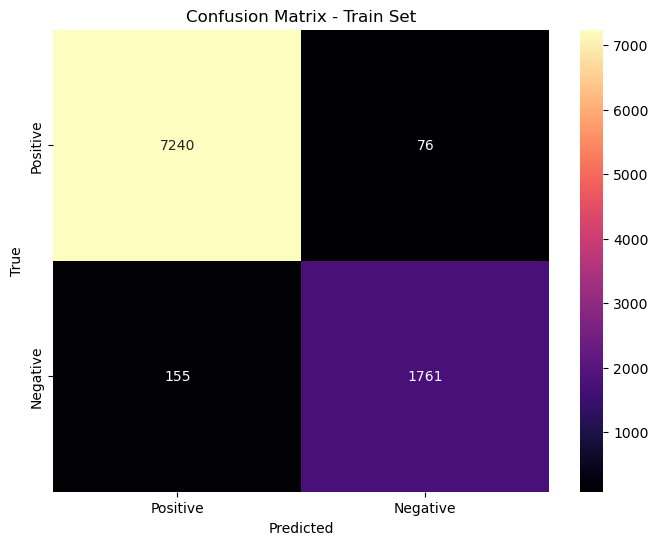

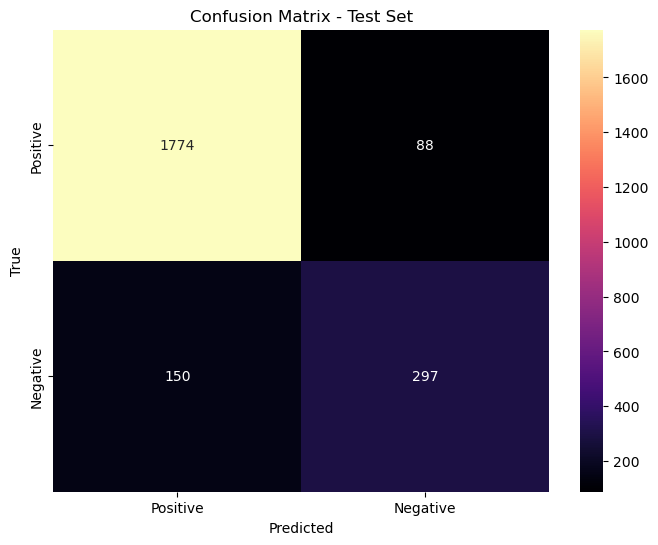

In [39]:
learning_rate = 0.001
# rnn = tf.keras.Sequential([
#     tf.keras.layers.Dense(512, activation='relu', input_shape=(X_tf_idf.shape[1],)),
#     tf.keras .layers.Dense(256,activation = 'relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
rnn = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_tf_idf.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=learning_rate)
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


rnn.fit(x_train.toarray(), y_train,epochs = 30)

    # Predict on training and test sets
train_predictions = (rnn.predict(x_train.toarray()) > 0.5).astype("int32").flatten()
test_predictions = (rnn.predict(x_test.toarray()) > 0.5).astype("int32").flatten()

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)


train_recall = recall_score(y_train, train_predictions, average='weighted')
test_recall = recall_score(y_test, test_predictions, average='weighted')
    
    
train_precision = precision_score(y_train, train_predictions, average='weighted')
test_precision = precision_score(y_test, test_predictions, average='weighted')
    

train_f1 = f1_score(y_train, train_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')

# # Evaluate the model
# loss, accuracy = model.evaluate(x_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f" Train Accuracy is : {train_accuracy}")
print(f" Test Accuracy is : {test_accuracy}")

print(f" Train Recall is : {train_recall}")
print(f" Test Recall is : {test_recall}")

print(f" Train F1 is : {train_f1}")
print(f" Test F1 is : {test_f1}")

print(f" Train Precision is : {train_precision}")
print(f" Test Precision is : {test_precision}")


plot_confusion_matrix(y_train, train_predictions, title='Confusion Matrix - Train Set')
plot_confusion_matrix(y_test, test_predictions, title='Confusion Matrix - Test Set')

scores2 = {
    'test_accuracy': test_accuracy,
    'test_recall': test_recall,
    'test_precision': test_precision,
    'test_f1': test_f1
}

In [ ]:

ksi = [('Naive Bayes', scores['train_accuracy'], scores['test_accuracy'], scores['train_precision'], scores['test_precision'],scores['train_f1'],scores['train_f1'],scores['train_recall'],scores['test_recall']),
       ('Decision Tree', dt_model['train_accuracy'], dt_model['test_accuracy'], dt_model['train_precision'], dt_model['test_precision'],dt_model['train_f1'],dt_model['train_f1'],dt_model['train_recall'],dt_model['test_recall']),
       ('RNN',  scores2['test_accuracy'],  scores2['test_precision'],scores2['test_f1'],scores2['test_recall']),
       ('LSTM',  lstm_scr['test_accuracy'], lstm_scr['test_precision'],lstm_scr['test_f1'],lstm_scr['test_recall']),
       ('SMO + DT',smo_dt['train_accuracy'], smo_dt['test_accuracy'], smo_dt['train_precision'], smo_dt['test_precision'],smo_dt['train_f1'],smo_dt['train_f1'],smo_dt['train_recall'],smo_dt['test_recall']),
       ('SVM', svm_model['train_accuracy'], svm_model['test_accuracy'], svm_model['train_precision'], svm_model['test_precision'],svm_model['train_f1'],svm_model['train_f1'],svm_model['train_recall'],svm_model['test_recall'])
       ]

Scores_ = pd.DataFrame(data=ksi, columns=['Classifiers', 'Train Accuracy', 'Test Accuracy', 'Train Precision', 'Test Precision', 'Train F1 Score','Test F1 Score','Train Recall','Test Recall'])
Scores_.set_index('Classifiers', inplace=True)

Scores_
